In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import pickle
import argparse

from utils.setup_funcs import *
from datasets.dsads_contig.dsads import *
from train import *
from models import *
from datasets.apply_policy import *
from sklearn.metrics import recall_score

def get_recall(model):
	_,_,test_loader = load_dsads_person_dataset(128)
	model.eval()

	with torch.no_grad():
		predictions = []
		labels = []
		outputs = []

		for batch_idx, (data,target) in enumerate(test_loader):

			# get model output
			out = model(data.float())

			# parse the output for the prediction
			prediction = out.argmax(dim=1).to('cpu')

			predictions.append(prediction)
			labels.append(target.to('cpu'))
		
		predictions = torch.cat(predictions).numpy()
		labels = torch.cat(labels).numpy()

		recall = recall_score(labels,predictions,average=None)
		return recall

def get_avg_duration(test_sequence_labels):
	labels = np.unique(test_sequence_labels)
	durations = np.zeros(len(labels))
	for label in labels:
		idxs = (test_sequence_labels == label).nonzero()[0]
		
		change_idxs = (idxs[1:]-idxs[:-1] > 1).nonzero()[0]
		change_idxs = np.concatenate([np.array([-1]),change_idxs,np.array([len(idxs)-1])])
		segment_lens = np.diff(change_idxs)
		avg_len = np.mean(segment_lens)
		durations[int(label)] = avg_len/25 # in seconds

	return durations

def get_avg_send_time(test_sequence_labels, packets):
	labels = np.unique(test_sequence_labels)
	durations = np.zeros(len(labels))

	# get the packet arrival points
	packet_arrival_idxs = (packets[0]*25).astype(int)

	for label in labels:
		# print(f"activ: {label}")
		idxs = (test_sequence_labels == label).nonzero()[0]
		change_idxs = (idxs[1:]-idxs[:-1] > 1).nonzero()[0]
		change_idxs = np.concatenate([np.array([-1]),change_idxs,np.array([len(idxs)-1])])
		segment_lens = np.diff(change_idxs)
		
		change_idxs[-1] -= 1
		starts = idxs[change_idxs+1][:-1]
		ends = starts + segment_lens

		t_send_avg = 0
		for start,end in zip(starts,ends):
			idxs_between = packet_arrival_idxs[(packet_arrival_idxs > start) & (packet_arrival_idxs < end)]
			if len(idxs_between) > 0:
				t_send_avg += (idxs_between[0]-start)
				# print(f"IDX: {start}, at least 1: {idxs_between[0]-start}")
			else:
				t_send_avg += end-start
				# print(f"IDX: {start}, none: {end-start}")

		durations[int(label)] = t_send_avg/len(starts)

	return durations



def gen_test_seq(data,labels,min_duration,max_duration,og_sampling_rate, seed):
	np.random.seed(seed)
	activity_idxs = {i : (labels == i).nonzero()[0] for i in np.unique(labels)}
	# print(activity_idxs)
	duration = np.arange(min_duration,max_duration+1)

	X = np.zeros_like(data)
	y = np.zeros_like(labels)

	activity_counters = np.zeros(len(np.unique(labels))) # keeps track of where we are
	remaining_activities = list(np.unique(labels))
	sample_counter = 0

	while len(remaining_activities) > 0:
		# randomly sample an activity
		act = int(np.random.choice(np.array(remaining_activities), 1)[0])

		# randomly sample a duration
		dur = np.random.choice(duration, 1)[0]

		# access this chunk of data and add to sequence
		# print(act)
		start = int(activity_counters[act])
		end = int(start + dur*og_sampling_rate)

		activity_counters[act] += (end-start)

		# check if hit end
		if end >= activity_idxs[act].shape[0]:
			end = int(activity_idxs[act].shape[0])-1
			remaining_activities.remove(act)
			print(remaining_activities)
		# print(activity_counters)
		# print(start,end)
		start = activity_idxs[act][start]
		end = activity_idxs[act][end]
		# print(start,end)
		X[sample_counter:sample_counter+end-start,:] = data[start:end,:]
		y[sample_counter:sample_counter+end-start] = labels[start:end]
		sample_counter += (end-start)

	return X,y

def error_decomp(dense_labels, dense_preds, packets):
	# first pad preds to be full time range so packet idxs are valid
	dense_preds = np.concatenate([np.zeros(len(dense_labels)-len(dense_preds)),dense_preds])

	# get the activity transition points (include starting point idx 0)
	activity_transition_idxs = np.concatenate([np.array([0]),np.where(dense_labels[:-1] != dense_labels[1:])[0] + 1])

	# get the packet arrival points
	packet_arrival_idxs = (packets[0]*25).astype(int)

	# get errors
	classif_total = 0
	classif_correct = 0
	transition_total = 0
	transition_correct = 0


	for i in range(-1,len(packet_arrival_idxs)-1):
		if i == -1:
			curr_packet_idx = 0 
		else:
			curr_packet_idx = packet_arrival_idxs[i]
		next_packet_idx = packet_arrival_idxs[i+1]

		# determine of there is a transition between the packets
		idxs_between = activity_transition_idxs[(activity_transition_idxs > curr_packet_idx) & (activity_transition_idxs < next_packet_idx)]
		if len(idxs_between) > 0:
			# some transition error
			# everything up until the first transition is classification error
			# everything after the first transition is transition error
			classif_total += (idxs_between[0] - curr_packet_idx)
			classif_correct += np.array((dense_labels[curr_packet_idx:idxs_between[0]] == dense_preds[curr_packet_idx:idxs_between[0]])).sum()
			transition_total += (next_packet_idx - idxs_between[0])
			transition_correct += np.array((dense_labels[idxs_between[0]:next_packet_idx] == dense_preds[idxs_between[0]:next_packet_idx])).sum()
		else:
			# all classif error
			classif_total += (next_packet_idx - curr_packet_idx)
			classif_correct += np.array((dense_labels[curr_packet_idx:next_packet_idx] == dense_preds[curr_packet_idx:next_packet_idx])).sum()
	
	# after the last packet is sent, there some remaining region left
	curr_packet_idx = next_packet_idx
	next_packet_idx = len(dense_labels)

	# determine of there is a transition between the packets
	idxs_between = activity_transition_idxs[(activity_transition_idxs > curr_packet_idx) & (activity_transition_idxs < next_packet_idx)]
	if len(idxs_between) > 0:
		# some transition error
		# everything up until the first transition is classification error
		# everything after the first transition is transition error
		classif_total += (idxs_between[0] - curr_packet_idx)
		classif_correct += np.array((dense_labels[curr_packet_idx:idxs_between[0]] == dense_preds[curr_packet_idx:idxs_between[0]])).sum()
		transition_total += (next_packet_idx - idxs_between[0])
		transition_correct += np.array((dense_labels[idxs_between[0]:next_packet_idx] == dense_preds[idxs_between[0]:next_packet_idx])).sum()
	else:
		# all classif error
		classif_total += (next_packet_idx - curr_packet_idx)
		classif_correct += np.array((dense_labels[curr_packet_idx:next_packet_idx] == dense_preds[curr_packet_idx:next_packet_idx])).sum()


	total_preds = len(dense_labels)
	opp_accuracy = np.array(dense_preds == dense_labels).mean()
	active_region = classif_total/total_preds
	passive_region = transition_total/total_preds
	active_error = (classif_total-classif_correct)/total_preds
	passive_error = (transition_total-transition_correct)/total_preds
	print(f"Total Preds: {total_preds}")
	print(f"Accuracy: {opp_accuracy}")
	print(f"Active Region Frac. Frac: {classif_total}/{total_preds} ({active_region}) -- {classif_correct} correct, {classif_total-classif_correct} incorrect")
	print(f"Passive Region Frac: {transition_total}/{total_preds} ({passive_region}) -- {transition_correct} correct, {transition_total-transition_correct} incorrect")
	print(f"Error: {1-opp_accuracy}, Active: {active_error}, Passive: {passive_error}")
	return opp_accuracy, active_error, passive_error

def region_decomp(dense_labels, packets):
	# get the activity transition points (include starting point idx 0)
	activity_transition_idxs = np.concatenate([np.array([0]),np.where(dense_labels[:-1] != dense_labels[1:])[0] + 1])

	# get the packet arrival points
	packet_arrival_idxs = (packets[0]*25).astype(int)

	# get errors
	active_region = 0
	passive_region = 0
	irred_passive = 0 # transition from passive to something else
	red_passive = 0 # transitions from active to something else

	for i in range(-1,len(packet_arrival_idxs)-1):
		if i == -1:
			curr_packet_idx = 0 
		else:
			curr_packet_idx = packet_arrival_idxs[i]
		next_packet_idx = packet_arrival_idxs[i+1]

		# determine of there is a transition between the packets
		idxs_between = activity_transition_idxs[(activity_transition_idxs > curr_packet_idx) & (activity_transition_idxs < next_packet_idx)]
		if len(idxs_between) > 0:
			# some transition error
			# everything up until the first transition is classification error
			# everything after the first transition is transition error
			active_region += (idxs_between[0] - curr_packet_idx)
			passive_region += (next_packet_idx - idxs_between[0])

			# active->passive is reducible
			if len(idxs_between) > 1:
				red_passive += (idxs_between[1]-idxs_between[0])
				irred_passive += (next_packet_idx - idxs_between[1])
			else:
				red_passive += (next_packet_idx - idxs_between[0])
		else:
			# all classif error
			active_region += (next_packet_idx - curr_packet_idx)
	
	# after the last packet is sent, there some remaining region left
	curr_packet_idx = next_packet_idx
	next_packet_idx = len(dense_labels)

	# determine of there is a transition between the packets
	idxs_between = activity_transition_idxs[(activity_transition_idxs > curr_packet_idx) & (activity_transition_idxs < next_packet_idx)]
	if len(idxs_between) > 0:
		# some transition error
			# everything up until the first transition is classification error
			# everything after the first transition is transition error
			active_region += (idxs_between[0] - curr_packet_idx)
			passive_region += (next_packet_idx - idxs_between[0])

			# active->passive is reducible
			if len(idxs_between) > 1:
				red_passive += (idxs_between[1]-idxs_between[0])
				irred_passive += (next_packet_idx - idxs_between[1])
			else:
				red_passive += (next_packet_idx - idxs_between[0])
	else:
		# all classif error
		active_region += (next_packet_idx - curr_packet_idx)

	return active_region, passive_region, irred_passive, red_passive

activities = np.load("../datasets/dsads_contig/activity_list.npy")

# load data
root_dir = os.path.expanduser("~/Projects/data/dsads/merged_preprocess")
train_data = np.load(f"{root_dir}/training_data.npy")
train_labels = np.load(f"{root_dir}/training_labels.npy")

val_data = np.load(f"{root_dir}/val_data.npy")
val_labels = np.load(f"{root_dir}/val_labels.npy")

test_data = np.load(f"{root_dir}/testing_data.npy")
test_labels = np.load(f"{root_dir}/testing_labels.npy")



In [18]:
test_data_seq, test_labels_seq = gen_test_seq(test_data, test_labels, 10, 30, 25, 0)

FS = 25 # sampling frequency
PACKET_SIZE = 8
LEAKAGE = 6e-6
INIT_OVERHEAD = 150e-6

# val_data = val_data[0:2000,:]
# val_labels = val_labels[0:2000]

eh = EnergyHarvester()

# add time axis
t_axis = np.arange(len(test_labels_seq))/FS
t_axis = np.expand_dims(t_axis,axis=0).T

# add the time axis to the data
full_data_window = np.concatenate([t_axis,test_data_seq],axis=1)

opp_packets, opp_e_trace = sparsify_data(full_data_window,PACKET_SIZE,LEAKAGE,INIT_OVERHEAD,eh,'opportunistic',train_mode=False)
t_send = get_avg_send_time(test_labels_seq,opp_packets)/25
t_dur = get_avg_duration(test_labels_seq)
is_active = t_send < 0.5*t_dur
orac_packets, orac_e_trace = sparsify_data(full_data_window,PACKET_SIZE,LEAKAGE,INIT_OVERHEAD,eh,'oracle_0.2',train_mode=False,label_sequence=test_labels_seq,is_active=is_active)

				

[0.0, 1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.0, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.0, 4.0, 6.0, 7.0, 8.0]
[4.0, 6.0, 7.0, 8.0]
[6.0, 7.0, 8.0]
[6.0, 8.0]
[6.0]
[]


In [20]:
a,p,i,r = region_decomp(test_labels_seq,opp_packets)
a_o,p_o,i_o,r_o = region_decomp(test_labels_seq,orac_packets)

In [30]:
print(a,p,i,r)
print(a_o,p_o,i_o,r_o)

60869 47131 18368 28763
77933 30067 10693 19374


In [32]:
p_o/(p_o+a_o)

0.2783981481481482

In [31]:
p/(p+a)

0.43639814814814815

In [11]:
print(get_avg_send_time(test_labels_seq,opp_packets)/25)
print(get_avg_send_time(test_labels_seq,orac_packets)/25)

[16.41391304 17.36222222 17.1826087  19.464       4.78095238  2.9047619   6.628       2.9408      4.17904762]
[ 7.88869565  8.83555556  3.26086957 15.388       4.99428571  3.03428571  6.976       3.1216      4.75428571]


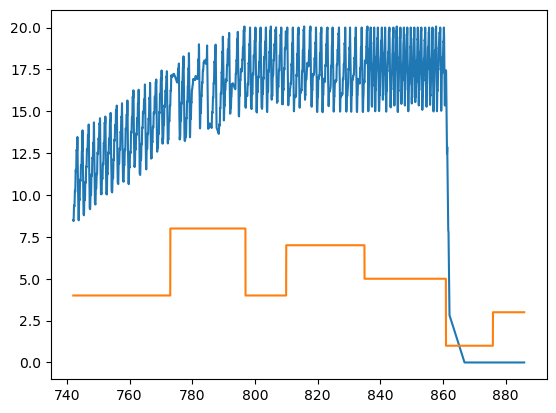

In [4]:
st = 20250-1700
en = 20250+1900
# plt.plot(t_axis[st:en],opp_e_trace[st:en]*10e4)
plt.plot(t_axis[st:en],orac_e_trace[st:en]*10e4)
plt.plot(t_axis[st:en],test_labels_seq[st:en])

In [72]:
labels = np.unique(test_labels_seq)
durations = np.zeros(len(labels))

# get the packet arrival points
packet_arrival_idxs = (opp_packets[0]*25).astype(int)

for label in labels:
    idxs = (test_labels_seq == label).nonzero()[0]
    change_idxs = (idxs[1:]-idxs[:-1] > 1).nonzero()[0]
    change_idxs = np.concatenate([np.array([-1]),change_idxs,np.array([len(idxs)-1])])
    segment_lens = np.diff(change_idxs)
    
    change_idxs[-1] -= 1
    starts = idxs[change_idxs+1][:-1]
    ends = starts + segment_lens

    t_send_avg = 0
    print(len(starts))
    for start,end in zip(starts,ends):
        idxs_between = packet_arrival_idxs[(packet_arrival_idxs > start) & (packet_arrival_idxs < end)]
        if label == 5 and len(idxs_between) > 0:
            print(idxs_between)

23
23
23
24
23
19
[ 99 127 153 180 210 236 262 289 314 342 370 393 419 448 476 503]
[1021 1048 1073 1105 1130 1154 1180 1208 1230 1258 1284 1307 1334 1359 1389 1412 1439 1466 1492 1520 1548 1575 1602]
[ 9940  9970  9999 10026 10052 10080 10101 10130 10154 10181 10206 10233 10263 10295 10322 10352 10380 10406 10433 10462 10489]
[15331 15359 15384 15412 15441 15468 15497 15525 15552 15580 15608 15637 15666 15694 15721 15744 15775 15807 15831 15858 15894 15924 15949 15977 16001 16027]
[20790 20817 20846 20878 20905 20944 20971 20999 21028 21055 21085 21112 21138 21166]
[21839 21870 21899 21928 21958 21989 22019 22050 22080 22109 22142 22169 22199 22226]
[31131 31158 31185 31214 31245 31273 31306 31333 31363 31393 31422 31450 31479 31508 31539 31570 31595 31625 31657 31687 31714 31742 31768]
[38953 38983 39011 39040 39070 39101 39127 39158 39187 39222]
[54457 54484 54519 54552 54580 54623 54659 54697]
[62565 62600 62627 62660 62694 62722 62759 62792 62822 62851 62879 62908 62936 62965 6299

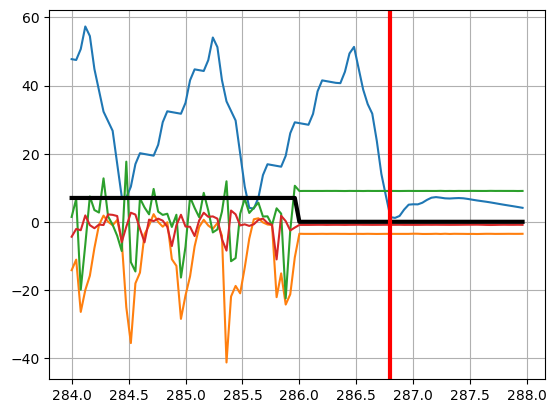

In [73]:
st = 7100
en = 7200
plt.plot(t_axis[st:en],opp_e_trace[st:en]*10e5)
plt.plot(t_axis[st:en],test_data_seq[st:en])
plt.plot(t_axis[st:en],test_labels_seq[st:en],c='k',linewidth=3)
plt.axvline(7170/25,c='r',linewidth=3)
plt.grid()

In [31]:
ener = np.load("e_out.npy")

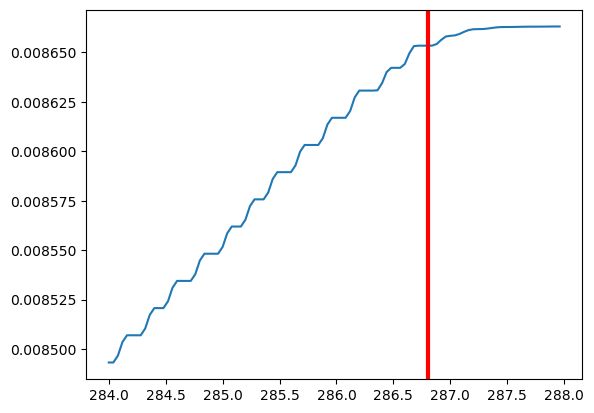

In [34]:
plt.plot(t_axis[st:en],ener[st:en])
plt.axvline(7170/25,c='r',linewidth=3)

In [84]:
data_window = full_data_window[st:en,:]
data_window[-80:,1:] = data_window[-1,1:]
channels = np.array([0,1,2,3]) # time + 3 acc channels of body part
df = pd.DataFrame(data_window[:,channels],columns=['time', 'x', 'y','z'])
eh = EnergyHarvester(spring_damp=0.03)
# get energy as function of samples
t_out, p_out = eh.power(df)
e_out = eh.energy(t_out, p_out)

In [1]:
plt.plot(t_out,data_window[:,1:])
plt.plot(t_out,p_out*10e4)
plt.grid()

NameError: name 'plt' is not defined

In [2]:
import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

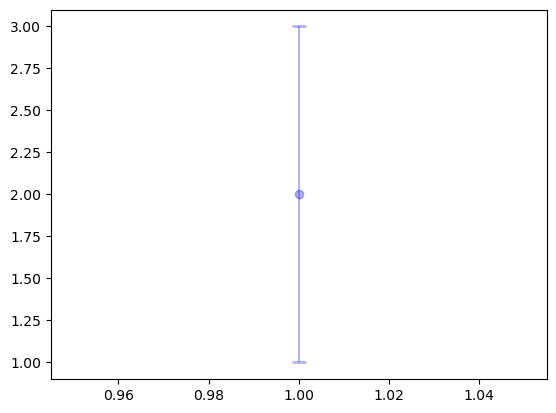

In [6]:
plt.errorbar([1],[2],yerr=1,marker='o',capsize=5,capthick=2, c='blue',alpha=0.3)


In [7]:
import numpy as np

In [8]:
ener = np.load("e_out.npy")

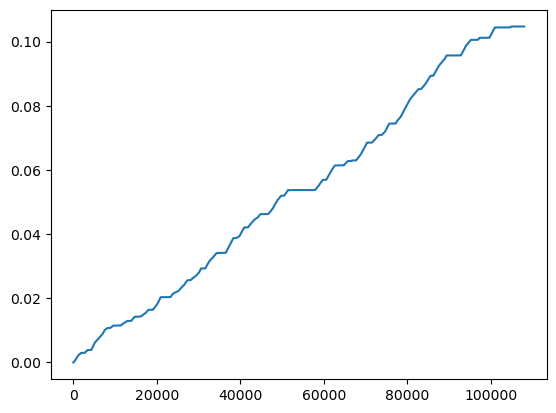

In [9]:
plt.plot(ener)